# Variable Electricity Prices

In [1]:
import requests
import json
import time
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates
import pytz

## Price Forecast from aWATTar for one Day
https://www.awattar.de/services/api

In [2]:
# https://www.tutorialspoint.com/python/time_strptime.htm
# https://statisticsglobe.com/convert-timedelta-integer-python

def get_time_for_request(day, month, year, timezone="CET", print_txt=False):    
    date_str = date(year=year, month=month, day=day).isoformat()+" 00 "+timezone
    req_time = time.strptime(date_str, "%Y-%m-%d %H %Z") # https://realpython.com/python-time-module/
    pst = pytz.timezone(timezone)
    daylight_saving = pst.localize(datetime(year, month, day)).dst() # during daylight saving time: 1:00:00
    req_time_number = time.mktime(req_time) - daylight_saving.total_seconds()
    req_time_number = int(req_time_number*1000)
    if print_txt:
        print(str(req_time_number), time.asctime(req_time))
    return str(req_time_number)
get_time_for_request(8,11,2021,print_txt=True);

1636326000000 Mon Nov  8 00:00:00 2021


In [3]:
def request_json_data_for_day(day, month, year):
    req_time_number = get_time_for_request(day, month, year)
    r = requests.get("https://api.awattar.de/v1/marketdata?start="+str(req_time_number))
    return json.loads(r.text)

In [4]:
r_json = request_json_data_for_day(8,11,2021)

In [5]:
def compute_brutto_per_kwh(net_stock_price):
    tax_rate     = 1.19
    service_rate = 1.03
    charges      = 13.036
    return tax_rate*net_stock_price*service_rate/10+charges # 13,036 Cent/kWh + EPEX Spot DE + |EPEX Spot DE| * 0,03

In [6]:
def get_data_for_day(data_json, print_txt=False):
    len_data = len(data_json)
    t_start = [] 
    price_netto  = [] 
    price_brutto = [] # zum Bruto Preis siehe Tarifblatt unter "https://www.awattar.de/tariffs/hourly" 
    for t in data_json:
        t_start.append(datetime.fromtimestamp(t['start_timestamp']/1000).strftime('%H'))
        price_netto.append(t['marketprice']/10)
        price_brutto.append(compute_brutto_per_kwh(t['marketprice']))
        if print_txt:
            print(datetime.fromtimestamp(t['start_timestamp']/1000).strftime('%H:%M:%S'),
                datetime.fromtimestamp(t['end_timestamp']/1000).strftime('%H:%M:%S'),
                t['marketprice']/10)

    end_last_segment = datetime.fromtimestamp(data_json[len_data-1]['end_timestamp']/1000).strftime('%H')
    t_start.append(' '+end_last_segment)
    price_netto.append(data_json[len_data-1]['marketprice']/10)
    #price_brutto.append(1.19*data_json[len_data-1]['marketprice']/10+13.04)
    price_brutto.append(compute_brutto_per_kwh(data_json[len_data-1]['marketprice']))
    return t_start, price_netto, price_brutto
get_data_for_day(r_json['data'],print_txt=False);

In [25]:
time_ticks, price_netto, price_brutto = get_data_for_day(r_json['data']);

In [8]:
def get_start_date(data_json):
    return datetime.fromtimestamp(data_json[0]['start_timestamp']/1000).strftime('%d.%m.%Y')
get_start_date(r_json['data'])

'08.11.2021'

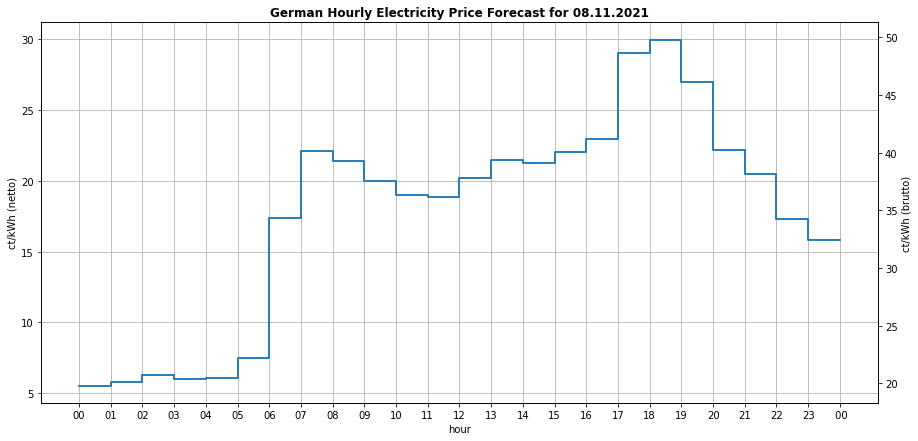

In [23]:
def plot_forecast_for_one_day(data_json):
    date_str = get_start_date(data_json)
    time_ticks, price_netto, price_brutto = get_data_for_day(data_json);
    fig, ax1 = plt.subplots(1, 1,figsize=(15,7))
    ax1.set_title('German Hourly Electricity Price Forecast for '+date_str, fontweight ="bold")
    ax1.plot(time_ticks, price_netto, drawstyle='steps-post')
    ax1.set_xlabel('hour')
    ax1.set_ylabel('ct/kWh (netto)')
    ax1.grid()
    ax2 = ax1.twinx()
    ax2.plot(time_ticks, price_brutto, drawstyle='steps-post') # same graph -> redundant
    ax2.set_ylabel('ct/kWh (brutto)');

plot_forecast_for_one_day(r_json['data'])

## Analyse aWATTar's Predictions over one Year

In [54]:
start_date = datetime(2022,  1, 1) # year, month, day
end_date   = datetime(2022, 12,31)
total_days = (end_date - start_date).days + 1 # inclusive start_date and end_date

data_json    = []
time_ticks   = []
date_of_data = []
price_netto  = np.zeros((25,total_days))
#print(price_netto.shape)
price_brutto = np.zeros((25,total_days))
for day_number in range(total_days):
    current_date = (start_date + timedelta(days = day_number)).date()
    #print(current_date.day, current_date.month, current_date.year)
    price_netto[0,day_number] = day_number
    r_json = request_json_data_for_day(current_date.day, current_date.month, current_date.year)
    date_of_data.append(r_json['data'][0]['start_timestamp'])
    data_json.append(r_json)
    time_ticks, tmp_netto, tmp_brutto = get_data_for_day(r_json['data']);
    tmp2d[:,0] = tmp
    price_netto[:,day_number]  = tmp_netto
    price_brutto[:,day_number] = tmp_brutto
#print(price_netto)

In [55]:
print(date_of_data[0:10])

[1640991600000, 1641078000000, 1641164400000, 1641250800000, 1641337200000, 1641423600000, 1641510000000, 1641596400000, 1641682800000, 1641769200000]


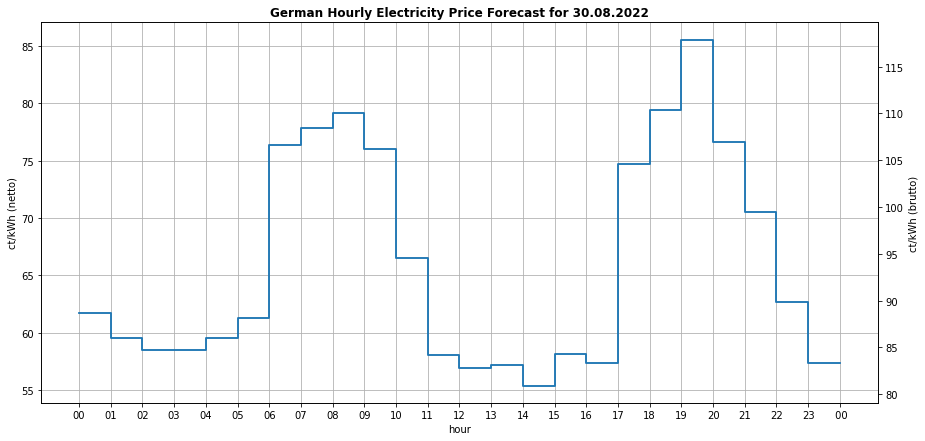

In [129]:
plot_forecast_for_one_day(data_json[241]['data'])

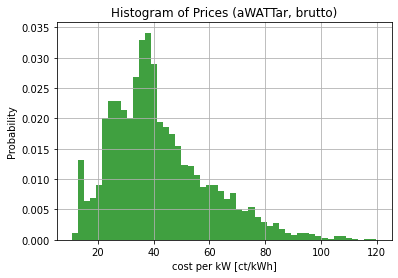

In [58]:
data_flat = price_brutto[0:-1,:].flatten()
n, bins, patches = plt.hist(data_flat, 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('cost per kW [ct/kWh]')
plt.ylabel('Probability')
plt.title('Histogram of Prices (aWATTar, brutto)')
plt.grid(True)
plt.show()

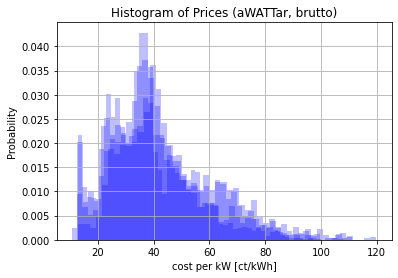

In [74]:
data_flat1 = price_brutto[0:6,:].flatten()
data_flat2 = price_brutto[6:12,:].flatten()
data_flat3 = price_brutto[12:18,:].flatten()
data_flat4 = price_brutto[18:24,:].flatten()
n, bins, patches = plt.hist(data_flat1, 50, density=True, facecolor='b', alpha=0.25)
n, bins, patches = plt.hist(data_flat2, 50, density=True, facecolor='b', alpha=0.25)
n, bins, patches = plt.hist(data_flat3, 50, density=True, facecolor='b', alpha=0.25)
n, bins, patches = plt.hist(data_flat4, 50, density=True, facecolor='b', alpha=0.25)
plt.xlabel('cost per kW [ct/kWh]')
plt.ylabel('Probability')
plt.title('Histogram of Prices (aWATTar, brutto)')
plt.grid(True)
plt.show()

plt.plot(average_days)

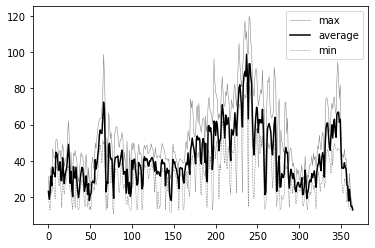

In [112]:
plt.plot(np.amax(price_brutto, axis=0), '-', color='black', label='max', alpha=0.5,linewidth=0.5);
plt.plot(np.average(price_brutto, axis=0), color='black', label='average');
plt.plot(np.amin(price_brutto, axis=0), '--', color='black', label='min', alpha=0.5,linewidth=0.5);
plt.legend();

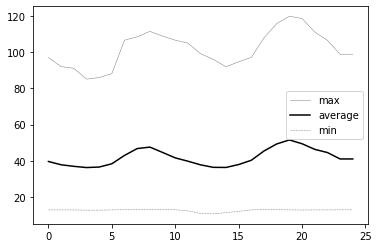

In [113]:
plt.plot(np.amax(price_brutto, axis=1), '-', color='black', label='max', alpha=0.5,linewidth=0.5);
plt.plot(np.average(price_brutto, axis=1), color='black', label='average');
plt.plot(np.amin(price_brutto, axis=1), '--', color='black', label='min', alpha=0.5,linewidth=0.5);
plt.legend();

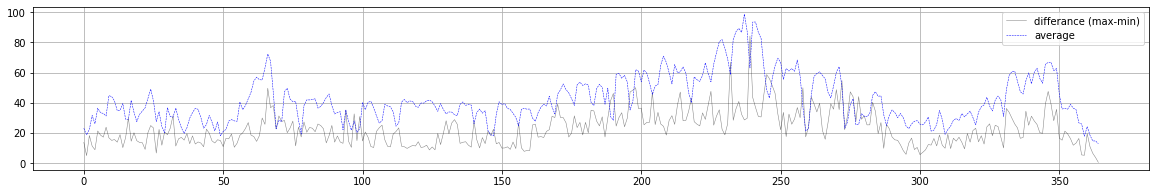

In [125]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(np.amax(price_brutto, axis=0)-np.amin(price_brutto, axis=0), '-', color='black', 
         label='differance (max-min)', alpha=0.5,linewidth=0.5);
plt.plot(np.average(price_brutto, axis=0), '--', color='blue', label='average',linewidth=0.5);
#plt.plot(np.amin(price_brutto, axis=1), '--', color='black', label='min', alpha=0.5,linewidth=0.5);
plt.grid()
plt.legend();